### Import Statements

In [1]:
import pandas as pd
from sentence_transformers import CrossEncoder
!pip install -q transformers
import pandas as pd
from transformers import pipeline
import torch
from transformers import RobertaModel, RobertaTokenizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error



/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


### Read articles dataframe in

In [3]:
df_articles = pd.read_csv("all_teams_data.csv")
df_articles = df_articles.rename(columns={'MetaData': 'Content'})
print((df_articles.head()))

        Team                                              Title  \
0  Air Force  10 reasons why Air Force football will embark ...   
1  Air Force  Air Force hosts Robert Morris to start 2023 se...   
2  Air Force  To keep wins coming, Air Force Falcons face 's...   
3  Air Force  Group of 5 Conferences: Preview and Prediction...   
4  Air Force   Air Force Football Announces New Fan Experiences   

                                             Content  
0                                     URL Not Parsed  
1  Air Force Falcons Game vs Robert Morris Game P...  
2  To keep wins coming, Air Force Falcons face ‘s...  
3  Group of 5 Conferences: Preview and Prediction...  
4  Air Force Academy Athletics Air Force Football...  


### Scrape team results

In [13]:
import requests
from bs4 import BeautifulSoup

url = 'https://www.sportsoddshistory.com/cfb-win/?y=2023&sa=cfb&t=win&o=t'

response = requests.get(url)
if response.status_code == 200:
    soup = BeautifulSoup(response.content, 'html.parser')

    rows = soup.find_all('tr')

    team_data = []
    for row in rows:
        columns = row.find_all('td')

        if len(columns) >= 6:
            team_name = columns[0].get_text(strip=True)
            win_prediction = columns[1].get_text(strip=True)
            odds_minus = columns[2].get_text(strip=True)
            odds_plus = columns[3].get_text(strip=True)
            adj_win_prediction = columns[4].get_text(strip=True)
            bet_type = columns[5].get_text(strip=True)

            team_data.append({
                'Team': team_name,
                'Win Prediction': win_prediction,
                'Odds Minus': odds_minus,
                'Odds Plus': odds_plus,
                'Actual Win': adj_win_prediction,
                'Bet Type': bet_type
            })

    df_teams = pd.DataFrame(team_data)
    df_teams['Actual Win'] = pd.to_numeric(df_teams['Actual Win'], errors='coerce')
    df_teams['Win Prediction'] = pd.to_numeric(df_teams['Win Prediction'], errors='coerce')

    df_teams['Win Diff'] = df_teams['Actual Win'] - df_teams['Win Prediction']

    print(df_teams)
else:
    print("Failed to retrieve the webpage:", response.status_code)


                  Team  Win Prediction Odds Minus Odds Plus  Actual Win  \
0            Air Force             8.5       -135      +115           8   
1                Akron             4.0       -135      +115           2   
2              Alabama            10.0       -155      +130          11   
3    Appalachian State             7.0       -105      -115           8   
4              Arizona             5.0       -130      +110           9   
..                 ...             ...        ...       ...         ...   
128      West Virginia             4.5       -150      +125           8   
129   Western Kentucky             8.5       +100      -120           7   
130   Western Michigan             3.5       -105      -115           4   
131          Wisconsin             8.5       -155      +130           7   
132            Wyoming             6.0       -120      +100           8   

    Bet Type  Win Diff  
0      Under      -0.5  
1      Under      -2.0  
2       Over       1.0  

In [14]:
df_all = df_teams.merge(df_articles, on='Team', how='inner')

In [15]:
print(df_all.columns)

Index(['Team', 'Win Prediction', 'Odds Minus', 'Odds Plus', 'Actual Win',
       'Bet Type', 'Win Diff', 'Title', 'Content'],
      dtype='object')


## Filter out bad data

In [16]:
print((df_all['Content'][1]))

Air Force Falcons Game vs Robert Morris Game Preview 2023 season - Mountain West Connection Skip to main content clock menu more-arrow no yes mobile Mountain West Connection homepage Horizontal - White Mountain West Connection a Mountain West Conference community Follow Mountain West Connection online: Follow Mountain West Connection on Twitter Follow Mountain West Connection on Facebook Log in or sign up Log In Sign Up Site search Search Search Mountain West Connection main menu Fanposts Sections Betting About Masthead Community Guidelines More All 300 communities on Horizontal - White Fanposts Sections Mountain West Basketball Mountain West Football The Good, The Bad, The Ugly Peak Perspective Mountain West Football Recruiting Full Archive Betting FanDuel College Football Odds FanDuel College Basketball Odds College Football Picks and Predictions College Basketball Picks and Predictions About Masthead Community Guidelines ✕ Filed under: Air Force Football Air Force hosts Robert Morri

In [17]:
df_all = df_all[df_all["Content"] != "URL Not Parsed"]

## Filter out irrelevant articles by using the embedding of the title

In [94]:
from sentence_transformers import SentenceTransformer
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

reference_query = "Looking ahead to football season preview and predictions. Get to know the team. Not past tense"

def get_embedding(text):
    embedding = model.encode([text])
    return embedding

reference_embedding = get_embedding(reference_query)

list_bad_titles = []
avg_embedding = []


def get_similarity(title):
    title_embedding = get_embedding(title)
    similarity_score = cosine_similarity(reference_embedding, title_embedding)[0][0]
    return similarity_score

def adjust_score_based_on_keywords(title, score):
    keywords = ['season', 'preview', 'prediction', 'predictions', 'examining', 'reasons']
    if any(keyword in title.lower() for keyword in keywords):
        score *= 1.5
    if score < 0.15:
        list_bad_titles.append((title, score))
    avg_embedding.append(score)
    return score

df_all['similarity'] = df_all['Title'].apply(lambda title: adjust_score_based_on_keywords(title, get_similarity(title)))

print(f"Mean of the embeddings: {np.mean(avg_embedding)}")
print(len(list_bad_titles))
print(list_bad_titles)


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.73k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Mean of the embeddings: 0.6716491950675845
16
[('App State Opens 2023 With High-Powered Home Victory', 0.046482638), ('Arizona Hosts NAU to Kick Off 2023 Campaign', 0.08087509), ("Army's New Offense: Why the Switch?", 0.081453875), ('Hungrier than ever', 0.08912028), ('Hungrier than ever', 0.08912028), ('Eastern Opens 2023 with 33-23 Home Win over Howard', 0.13876958), ("Hawaii Prep World's post", 0.108509466), ("'Focused' Liberty low on experience, high on optimism this ...", 0.1306361), ('ULM Welcomes Lamar; Seeks First 2-0 Start Since 2018', 0.10499385), ("Murray's Mailbag: What are the best- and worst-case ...", 0.12179332), ("What's The Best-Case And Worst-Case Situation For ...", 0.089712515), ('Oregon State Opens 2023 Ranked 18th In AP Top 25', 0.0493986), ('Owls Select Seven Captains for 2023', 0.1488316), ('Air Force holds off Kats 13-3', 0.12214014), ('Temple 2024 recruiting: Flying too low to ground', 0.10697724), ('Wisconsin Is Done Doing the Same Old Thing', 0.028992515)]


## Perform sentiment Analysis on articles

In [36]:
import pandas as pd
from transformers import pipeline

counter = 0


sentiment_pipeline = pipeline("sentiment-analysis")
df_all['Sentiment'] = None

def get_sentiment(text):
    result = sentiment_pipeline(text)
    return result[0]['label'], result[0]['score']

def analyze_content_sentiment(content):
    chunk_size = 1000
    num_chunks = (len(content) // chunk_size) + 1
    total_score = 0
    count = 0

    for i in range(num_chunks):
        chunk = content[i * chunk_size: (i + 1) * chunk_size]
        sentiment_label, sentiment_score = get_sentiment(chunk)

        if sentiment_label == 'NEGATIVE':
            sentiment_score *= -1
        total_score += sentiment_score
        count += 1

    avg_sentiment_score = total_score / count if count > 0 else 0
    return avg_sentiment_score

for index, row in df_all.iterrows():
    # if index == 80:
    #   break
    content = row['Content']
    avg_sentiment_score = analyze_content_sentiment(content)
    df_all.at[index, 'Sentiment'] = avg_sentiment_score
    counter += 1
    print(counter)

print(df_all)


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [37]:
df_all.to_csv("all_teams_data_sentiment.csv")

In [38]:
df_team_sentiment_avg = df_all.groupby('Team', as_index=False).agg({
    'Sentiment': 'mean',
    'Win Diff': lambda x: x.mode()[0],
    'Bet Type': lambda x: x.mode()[0],
})

df_team_sentiment_avg.rename(columns={'Sentiment': 'Sentiment_Avg'}, inplace=True)

df_team_sentiment_avg.to_csv("all_teams_data_sentiment_full.csv")

## Drop if Push result (edge cases)

In [86]:
df_team_sentiment_avg = df_team_sentiment_avg.reset_index(drop=True)

for index, row in df_team_sentiment_avg.iterrows():
    # print(row["Bet Type"])
    if row["Bet Type"] != 'Under' and row["Bet Type"] != 'Over':
        df_team_sentiment_avg.drop(index, inplace=True)


Under
Under
Over
Over
Over
Under
Under
Over
Under
Under
Under
Under
Under
Over
Over
Under
Over
Under
Under
Under
Under
Under
Under
Over
Under
Under
Under
Under
Under
Over
Over
Over
Under
Over
Over
Under
Under
Under
Over
Over
Over
Over
Under
Under
Over
Under
Under
Under
Over
Under
Under
Over
Under
Over
Over
Under
Under
Under
Over
Over
Under
Under
Under
Over
Over
Over
Over
Over
Over
Over
Over
Over
Over
Over
Under
Over
Under
Under
Over
Over
Over
Under
Under
Over
Under
Over
Under
Over
Under
Under
Under
Over
Under
Under
Over
Under
Over
Over
Under
Under
Over
Under
Under
Over
Under
Over
Under
Over
Under
Over
Under
Over
Under
Over


In [88]:
df_team_sentiment_avg = pd.read_csv("all_teams_data_sentiment_full.csv")

In [105]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

df = df_team_sentiment_avg
X = df[['Sentiment_Avg']]
y = df['Win Diff']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 3.3171764072001624
R-squared: -0.02545207213662004


## Show the overall accuracy if making a binary over / under prediction

In [106]:
y_pred_bet = ['Under' if pred < 0 else 'Over' for pred in y_pred]

accuracy = accuracy_score(y_test.apply(lambda x: 'Under' if x < 0 else 'Over'), y_pred_bet)

print(f"Accuracy: {accuracy}")

Accuracy: 0.5135135135135135


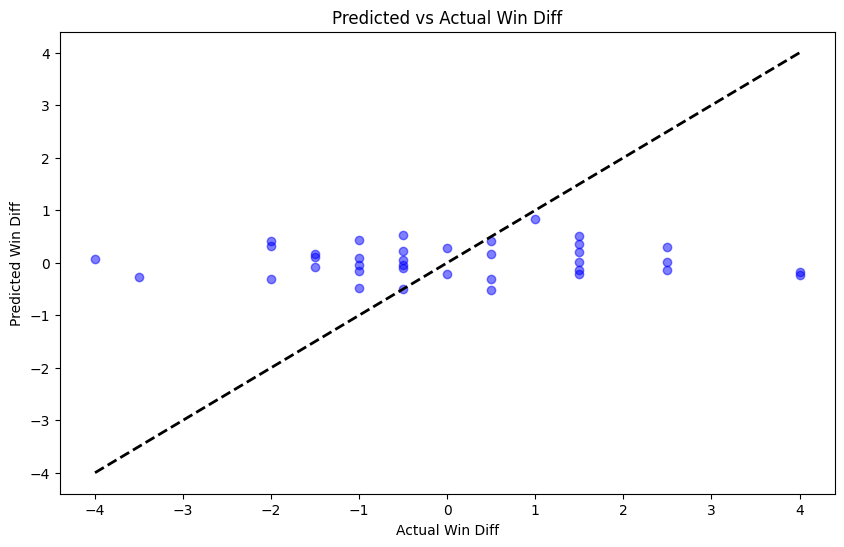

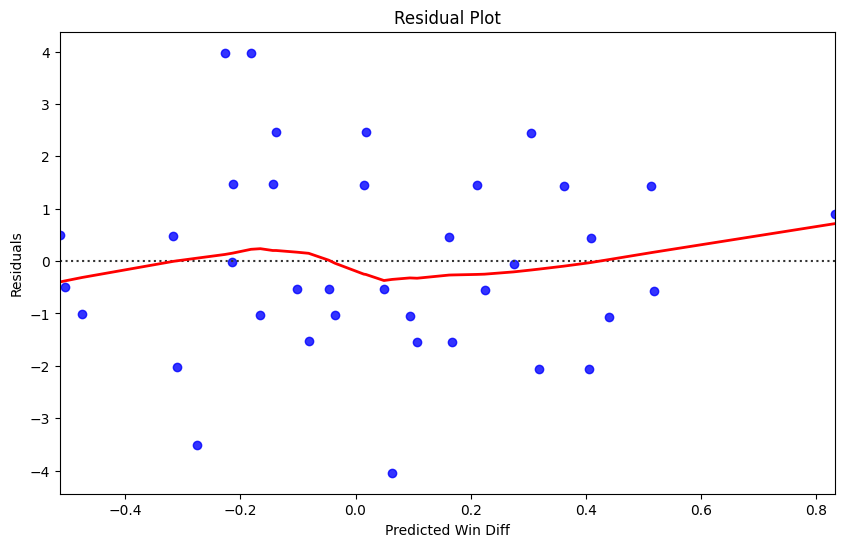

In [107]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.title("Predicted vs Actual Win Diff")
plt.xlabel("Actual Win Diff")
plt.ylabel("Predicted Win Diff")
plt.show()

residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.residplot(x=y_pred, y=residuals, lowess=True, color='blue', line_kws={'color': 'red', 'lw': 2})
plt.title("Residual Plot")
plt.xlabel("Predicted Win Diff")
plt.ylabel("Residuals")
plt.show()


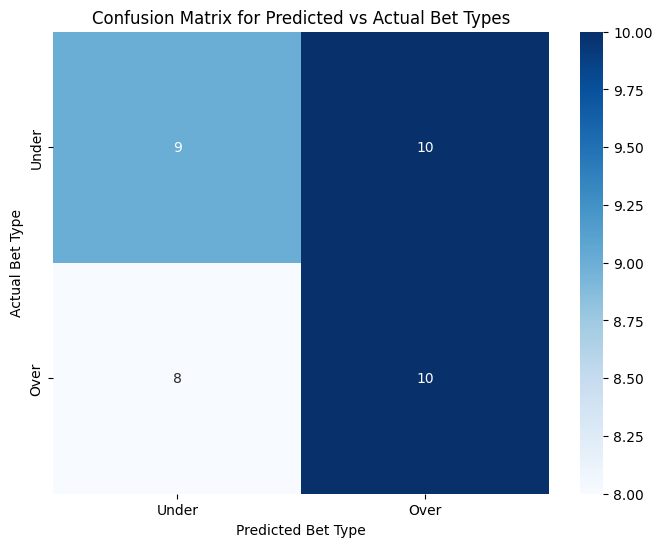

In [108]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

y_test_bet = y_test.apply(lambda x: 'Under' if x < 0 else 'Over')
y_pred_bet = ['Under' if pred < 0 else 'Over' for pred in y_pred]

cm = confusion_matrix(y_test_bet, y_pred_bet, labels=['Under', 'Over'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Under', 'Over'], yticklabels=['Under', 'Over'])
plt.xlabel("Predicted Bet Type")
plt.ylabel("Actual Bet Type")
plt.title("Confusion Matrix for Predicted vs Actual Bet Types")
plt.show()
